# Exciton-Polaritons in Lattices

**by Dmitry R. Gulevich <br>
ITMO University, St Petersburg, Russia**

Python code to simulate exciton-polaritons in lattices.

In [2]:
import math
import numpy as np
import matplotlib.pyplot as plt
import exp2d
%matplotlib inline

In [101]:
import imp
imp.reload(exp2d)

<module 'exp2d' from '/home/dimitry/Desktop/RESEARCH 2018/SpinorGP code/exp2d/exp2d.py'>

# 1. Setting up the model

In [4]:
me=9.1e-31 # electron mass, kg
meff=5.0e-5*me # exciton-polariton effective mass, kg
hbar=1.05e-34 # reduced Planck constant, J s
dum=3. # micron
d=dum*1.e-6 # m
E0=hbar*hbar/(2.*meff*d*d)/(1.6e-22) # characteristic energy, meV
print('E0 = %f meV' % E0)

E0 = 0.084135 meV


In [103]:
M=20 # should be even number
assert M%2==0
Mhalf=round(M/2)
Umax=20. # height of the potential
aum = 2.9 # um
dum = 3.0 # um
Lconstant=2.*aum # um
Rpillar=0.5*dum # radius if the pillar in um

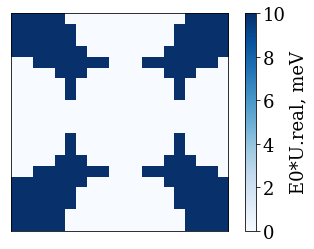

In [161]:
dr=1./M
dr2=dr*dr

UinmeV=0.-0.1*1j # meV
UoutmeV=10-0.5*1j # meV

U = exp2d.U_Lieb(M, Rpillar/Lconstant, UinmeV/E0, UoutmeV/E0)  # create potential

cmap=plt.get_cmap('Blues')
img=plt.imshow(E0*U.real.T,interpolation='nearest', cmap = cmap, origin='lower')
plt.xticks([])
plt.yticks([])
plt.colorbar(img,cmap=cmap,label='E0*U.real, meV')
plt.show()

# 2. Band structure and eigenstates

In [144]:
NBzones=3

In [147]:
# Calculate eigenenergies for ky=np.pi, NBzones=2, Nvals=30, Nkpoints=70
%time kxrange,evlist=exp2d.calc_bands(M, U, np.pi, NBzones, 30, 70)

CPU times: user 3.33 s, sys: 40 ms, total: 3.37 s
Wall time: 1.69 s


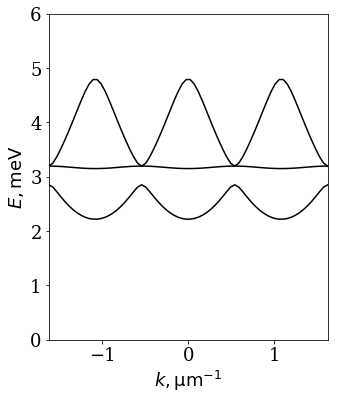

In [148]:
### Source: cbands.py

plt.rc('font', family='serif', size=18)
fig, ax = plt.subplots(figsize=(5,6))

for i in range(evlist.shape[1]):
    ax.plot(kxrange/Lconstant,E0*evlist[:,i],'k')

ax.set_xlim([kxrange[0]/Lconstant,kxrange[-1]/Lconstant])
ax.set_ylim([0,6])
ax.set_xlabel(r"$k, \rm \mu m^{-1}$")
ax.set_ylabel(r"$E, \rm meV$")
#ax.set_xticks([-np.pi,0,np.pi])
plt.show()

In [149]:
evals,evecs = exp2d.calc_vectors(M, U, np.pi, np.pi, 30)

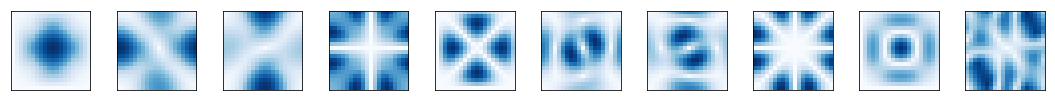

In [150]:
nvmax=10 # number of eigenvectors to display
plt.rc('font', family='serif', size=18)
fig, ax = plt.subplots(1,nvmax,figsize=(15,2))

cmap=plt.get_cmap('Blues')

for nv in range(nvmax):
    data=np.abs(evecs[nv]).reshape(M,M)
    ax[nv].imshow(data.T,interpolation='nearest', cmap = cmap, origin='lower')
    ax[nv].set_xticks([])
    ax[nv].set_yticks([])

plt.tight_layout()
plt.show()

# 3. Dynamics

In [151]:
#Ncells=12 # used for production
Ncells=8 # integer number for symmetric display
#nvrange=range(16) # used for production
nvrange=range(10)
dk=2.*np.pi/Ncells

In [152]:
Mglobal=Ncells*M
Uglobal=np.zeros((Mglobal,Mglobal),dtype=np.complex128)
for i in range(Ncells):
    for j in range(Ncells):
        Uglobal[i*M:(i+1)*M,j*M:(j+1)*M] = np.copy(U[:,:])

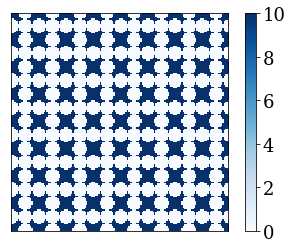

In [153]:
cmap=plt.get_cmap('Blues')
data=E0*Uglobal.real
img=plt.imshow(data.T,interpolation='nearest', cmap = cmap, origin='lower')
plt.xticks([])
plt.yticks([])
plt.colorbar(img,cmap=cmap)
plt.show()

In [154]:
### Initialization of Psi with a single eigenmode
# nv=4
# kx=0.
# ky=0.
# evals,evecs = exp2d.calc_vectors(M, U, kx, ky, 30)
# psi=evecs[nv].reshape(M,M)

# Psi=np.zeros((Ncells*M,Ncells*M),dtype=np.complex128)
# for i in range(Ncells):
#     for j in range(Ncells):
#         Psi[i*M:(i+1)*M,j*M:(j+1)*M] = psi[:,:]*np.exp(1j*(kx*i+ky*j))

# print('# Initialized at kx=%f, ky=%f, nv=%d' % (kx,ky,nv))

# interpolation='nearest'
# #interpolation='gaussian'
# #interpolation=None
# cmap=plt.get_cmap('Blues_r')
# data=(Psi*np.conjugate(Psi)).real
# img=plt.imshow(data.T,interpolation=interpolation, cmap = cmap, origin='lower')
# plt.colorbar(img,cmap=cmap)
# plt.show()

In [155]:
# interpolation='nearest'
# cmap=plt.get_cmap('Blues_r')
# data=(Psi*np.conjugate(Psi)).real
# img=plt.imshow(data.T,interpolation=interpolation, cmap = cmap, origin='lower')
# plt.colorbar(img,cmap=cmap)
# plt.show()

In [156]:
import time
from scipy.sparse import csc_matrix
from scipy.sparse import dia_matrix
from scipy.sparse import linalg

Nvals=30

### Constructing matrix
Imat=np.ones(M*M,dtype=np.complex128)
Itop=np.ones(M,dtype=np.complex128)
Itop[0]=0.
Itopmat=np.array([Itop]*M).ravel()
Ibot=np.ones(M,dtype=np.complex128)
Ibot[-1]=0.
Ibotmat=np.array([Ibot]*M).ravel()

offset=[-(M-1),-M*(M-1),-M,-1,0,1,M,M*(M-1),M-1]
u=np.empty((M,M),dtype=np.complex128)

Psi=np.zeros((Ncells*M,Ncells*M),dtype=np.complex128)
evecslist=[]

start_time = time.time()

# Loop over BZ
for n in range(Ncells):
#for n in [int(Ncells/2)]:
    ky=-np.pi+n*dk

    eky=np.exp(-1j*ky)
    ekytop=np.zeros(M,dtype=np.complex128)
    ekybot=np.zeros(M,dtype=np.complex128)
    ekytop[-1]=-eky
    ekybot[0]=-np.conjugate(eky)
    topmat=np.array([ekytop]*M).ravel()
    botmat=np.array([ekybot]*M).ravel()


    for m in range(Ncells):

        # skip G and K points
        #if((n==int(Ncells/2) and m==int(Ncells/2)) or (n==0 and m==0)):
        #    continue

        kx=-np.pi+m*dk
        ekx=np.exp(-1j*kx)
        data=[botmat,-Imat*np.conjugate(ekx),-Imat,-Ibotmat,4.*Imat + dr2*U.real.ravel(),-Itopmat,-Imat,
              -Imat*ekx,topmat]
        dmatrix=dia_matrix((data, offset), shape=(M*M, M*M))
        spmatrix=csc_matrix(dmatrix)
        evalsunsorted,Tevecs=linalg.eigsh(spmatrix, return_eigenvectors=True, k=Nvals, sigma=0)
        evalsunsorted/=dr2
        evecsunsorted=Tevecs.T
    
        inds=np.argsort(evalsunsorted)
        evals=evalsunsorted[inds]
        evecs=evecsunsorted[inds]
        ens=E0*evals

        evecslist.append(evecs[0:len(nvrange),:].ravel())
        

evecsarr=np.array(evecslist).reshape(Ncells,Ncells,len(nvrange),M*M)

print('#')
print("# Timing: %.f seconds" % (time.time()-start_time))
print('#')

#
# Timing: 2 seconds
#


In [157]:
from numpy.ctypeslib import ndpointer, load_library
from ctypes import *

### === C library interface ===
libcd = load_library("liblattice.so", ".")
libcd.lattice.restype = None
libcd.lattice.argtypes = [ndpointer(dtype=np.complex128, ndim=2, flags='C_CONTIGUOUS'), 
        ndpointer(dtype=np.complex128, ndim=3, flags='C_CONTIGUOUS'),
        c_int, c_int, c_double, c_double, c_int, c_int,
        ndpointer(dtype=np.complex128, ndim=2, flags='C_CONTIGUOUS')]

#libcd.omp_set_num_threads(2) # set number of OpenMP threads

'''
#dt=0.002
dt=0.001
dtout=0.05
tstart=0.
countout=int(dtout/dt)
Nframes=50
NPKY=6
'''

#dt=0.001
dt=0.002
dtout=0.05
tstart=0.
countout=int(dtout/dt)
Nframes=20 # 200
Nsamples=4 # 40
NPKY=6

dkx=2.*np.pi/Ncells;
kmax=NBzones*np.pi
dE=2.*np.pi*E0/(Nframes*dtout)
Emin=0.5
Emax=5.2

FPsiarr=np.empty((Nframes,NPKY,Mglobal),dtype=np.complex128)

probsum=np.zeros((NPKY,round(Emax/dE)-round(Emin/dE),
                  1+int(Mglobal*0.5+kmax/dkx)-int(Mglobal*0.5-kmax/dkx)), dtype=np.float64)

for sample in range(Nsamples):

    print("# Sample %d: " % sample)
    Psi=np.zeros((Mglobal,Mglobal),dtype=np.complex128)

    # Loop over BZ
    for n in range(Ncells):
        ky=-np.pi+n*dk
        for m in range(Ncells):
            kx=-np.pi+m*dk
            for nv in nvrange:

                psi=np.copy(evecsarr[n,m,nv].reshape(M,M))

                randphase = np.exp(1j*2.*np.pi*np.random.random_sample())
                for i in range(Ncells):
                    for j in range(Ncells):
                        Psi[i*M:(i+1)*M,j*M:(j+1)*M] += randphase*psi[:,:]*np.exp(1j*(kx*i+ky*j))

    libcd.lattice(Psi,FPsiarr,Ncells,Mhalf,tstart,dt,Nframes,countout,Uglobal)

    for Pky in range(NPKY):
        fftarr=np.fft.fftshift(np.fft.fft(FPsiarr[:,Pky,:],axis=0),axes=1)
        data=(fftarr*np.conjugate(fftarr)).real
        data1=data[::-1]
        data2=data1[round(Emin/dE):round(Emax/dE),int(Mglobal*0.5-kmax/dkx):int(Mglobal*0.5+kmax/dkx)+1]
        probsum[Pky,:,:] += data2
        
print('done')

#%time libcd.lattice(Psi,FPsiarr,Ncells,Mhalf,tstart,dt,Nframes,countout,Uglobal)

# Sample 0: 
# Sample 1: 
# Sample 2: 
# Sample 3: 
done


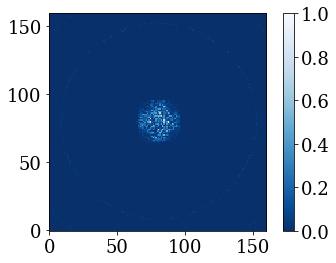

In [158]:
interpolation='nearest'
#interpolation='gaussian'
#interpolation=None

vmax=1
FPsi=np.fft.fftshift(np.fft.fft2(Psi))

cmap=plt.get_cmap('Blues_r')
Rho=(FPsi*np.conjugate(FPsi)).real
data=Rho/np.max(Rho)
#extent=[-0.5*dk*Mglobal/dum,0.5*dk*Mglobal/dum,-0.5*dk*Mglobal/dum,0.5*dk*Mglobal/dum]
#img=plt.imshow(data.T,interpolation=interpolation, cmap = cmap, origin='lower',extent=extent, vmax=vmax)
img=plt.imshow(data.T,interpolation=interpolation, cmap = cmap, origin='lower', vmax=vmax)
plt.colorbar(img,cmap=cmap)
plt.show()

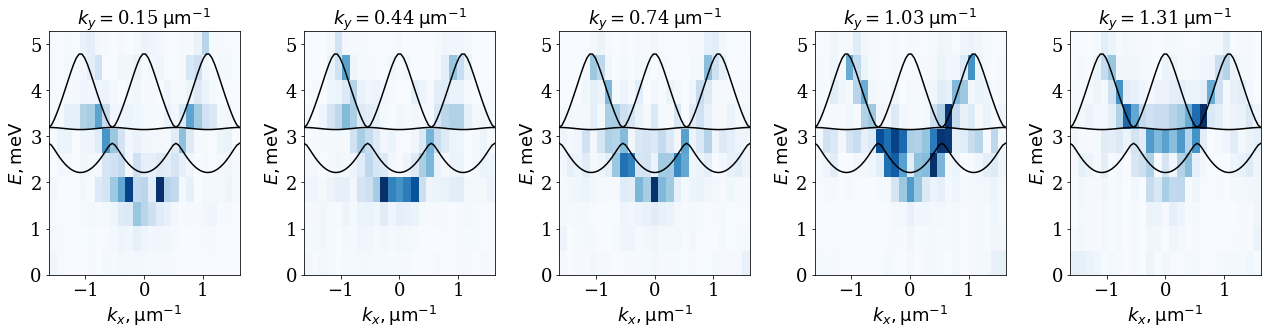

In [159]:
plt.rc('font', family='serif')
plt.rc('font', size='18')

kylist_local=np.array([0., 0.15, 0.44, 0.74, 1.03, 1.31]);

fig, ax = plt.subplots(1, 5, figsize=(18,5))

from matplotlib.colors import LinearSegmentedColormap
cdict = {'red':   ((0.0, 1.0, 1.0),
                   (0.3, 0.0, 0.0),
                   (0.75, 1.0, 1.0),
                   (1.0, 1.0, 1.0)),

         'green': ((0.0, 1.0, 1.0),
                   (0.3, 0.0, 0.0),
                   (0.75, 0.0, 0.0),
                   (1.0, 0.8, 0.8)),

         'blue':  ((0.0, 1.0, 1.0),
                   (0.3, 0.5, 0.5),
                   (0.75, 0.0, 0.0),
                   (1.0, 0.0, 0.0))
        }

#cmap = LinearSegmentedColormap('mycmap', cdict)
cmap=plt.get_cmap('Blues')

vmax=1.

Ntstart=int(0.*Nframes)
Ntfinish=int(1*Nframes)


for Pky in [1,2,3,4,5]:
#for Pky in [2]:
    i=Pky-1

    fftarr=np.fft.fftshift(np.fft.fft(FPsiarr[Ntstart:Ntfinish,Pky,:],axis=0),axes=1)
    Nframecut=fftarr.shape[0]

    data=(fftarr*np.conjugate(fftarr)).real
    data1=data[::-1]

    dE=2.*np.pi*E0/(Nframecut*dtout)
    Emax=0.5*Nframecut*dE

    data2=data1[0:int(0.5*Nframecut),int(Mglobal*0.5-kmax/dkx):int(Mglobal*0.5+kmax/dkx)+1]   
    data3=data2/np.max(data2)
    img=ax[i].imshow(data3,aspect='auto', interpolation='nearest', extent=[-kmax/Lconstant,kmax/Lconstant,0,Emax], cmap = cmap, 
                     origin='lower',vmax=vmax)
    #img=ax.imshow(data3,aspect='auto', extent=[-kmax,kmax,0,Emax], cmap = cmap, origin='lower',vmax=vmax)
    #img=ax.imshow(data3,aspect='auto', cmap = cmap, origin='lower')
    #img=imshow(data[::-1], aspect='auto', cmap = cmap, origin='lower',vmax=vmax)
    #colorbar(img,cmap=cmap)
    ax[i].set_xlabel("k")
    #ax[i].set_xticks([-2,-1,0,1,2])
    
    ax[i].set_title(r'$k_y=$'+str(kylist_local[Pky])+r'$\rm\; \mu m^{-1}$', fontsize=18)

ax[0].set_ylabel("E, meV")
#fig.subplots_adjust(hspace=0.8)

cmap=plt.get_cmap('Blues')

### ---  Band Structure ---

for nax in range(5):
    for i in range(evlist.shape[1]):
        ax[nax].plot(kxrange/Lconstant,E0*evlist[:,i],'k')  

    ax[nax].set_xlim([-kmax/Lconstant,kmax/Lconstant])
    ax[nax].set_ylim([0,Emax])
    ax[nax].set_xlabel(r"$k_x, \rm \mu m^{-1}$")
    ax[nax].set_ylabel(r"$E, \rm meV$")
    #ax[nax].set_xticks([-2,-1,0,1,2])

plt.tight_layout()

plt.show()

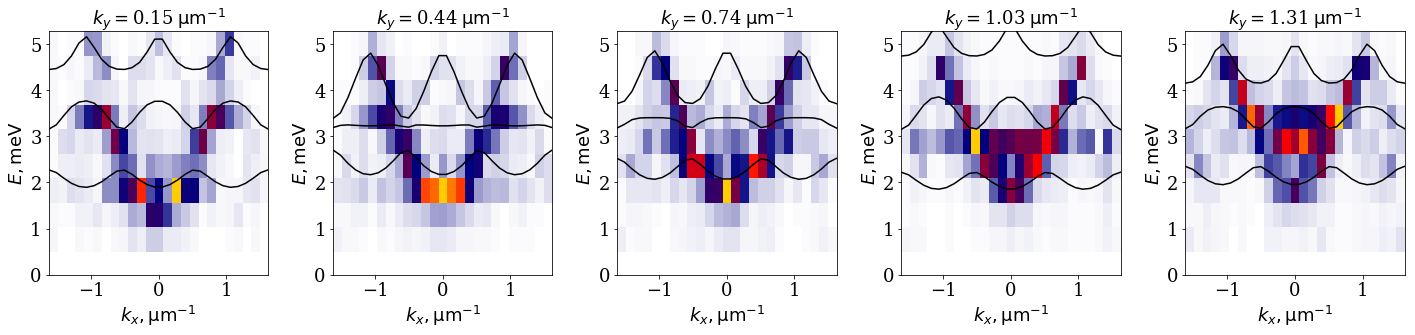

In [172]:
plt.rc('font', family='serif')
plt.rc('font', size='18')

interpolation=None
#interpolation='nearest'

kylist_local=np.array([0., 0.15, 0.44, 0.74, 1.03, 1.31]);

fig, ax = plt.subplots(1, 5, figsize=(20,5))

from matplotlib.colors import LinearSegmentedColormap
cdict = {'red':   ((0.0, 1.0, 1.0),
                   (0.3, 0.0, 0.0),
                   (0.75, 1.0, 1.0),
                   (1.0, 1.0, 1.0)),

         'green': ((0.0, 1.0, 1.0),
                   (0.3, 0.0, 0.0),
                   (0.75, 0.0, 0.0),
                   (1.0, 0.8, 0.8)),

         'blue':  ((0.0, 1.0, 1.0),
                   (0.3, 0.5, 0.5),
                   (0.75, 0.0, 0.0),
                   (1.0, 0.0, 0.0))
        }

cmap = LinearSegmentedColormap('mycmap', cdict)
#cmap=plt.get_cmap('Blues')

for Pky in [1,2,3,4,5]:
    i=Pky-1
    img=ax[i].imshow(probsum[Pky],aspect='auto', interpolation=interpolation, extent=[-kmax/Lconstant,kmax/Lconstant,Emin,Emax], cmap = cmap, origin='lower')
    #colorbar(img,cmap=cmap)
    ax[i].set_xlabel(r'$k_x,\;\mu m^{-1}$')
    ax[i].set_xticks([-2,-1,0,1,2])

#    props = dict(boxstyle='round',facecolor='white', alpha=1)
#    ax[i].text(0.05, 0.1, r'$k_y=$'+str(kylist_local[Pky])+r'$\rm\; \mu m^{-1}$', transform=ax[i].transAxes, fontsize=15, verticalalignment='top', bbox=props)
#    ax[i].text(0.05, 0.95, r'$k_y=$'+str(kylist_local[Pky])+r'$\rm\; \mu m^{-1}$', transform=ax[i].transAxes, fontsize=18, verticalalignment='top')

    ax[i].set_title(r'$k_y=$'+str(kylist_local[Pky])+r'$\rm\; \mu m^{-1}$', fontsize=18)

ax[0].set_ylabel(r'$E,\;\rm meV$')
#fig.subplots_adjust(hspace=0.8)

### ---  Band Structure ---

for Pky in [1,2,3,4,5]:
    nax=Pky-1
    ky = Lconstant*kylist_local[Pky] # normalized
    kxrange,evlist=exp2d.calc_bands(M, U, ky, NBzones, 5, 30)

    for i in range(evlist.shape[1]):
        ax[nax].plot(kxrange/Lconstant,E0*evlist[:,i],'k')  

    ax[nax].set_xlim([-kmax/Lconstant,kmax/Lconstant])
    ax[nax].set_ylim([0,Emax])
    ax[nax].set_xlabel(r"$k_x, \rm \mu m^{-1}$")
    ax[nax].set_ylabel(r"$E, \rm meV$")
    #ax[nax].set_xticks([-2,-1,0,1,2])

plt.tight_layout()

plt.show()